In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from params import subject_keys, eeg_chans, run_keys
from compute_power_at_resp import power_at_resp_job
from bibliotheque import get_pos, init_nan_da, df_baseline
import mne
import os
from configuration import base_folder

In [2]:
concat = []
for run_key in run_keys:
    participant, session = run_key.split('_')
    power_at_resp_participant = power_at_resp_job.get(run_key).to_dataframe()
    concat.append(power_at_resp_participant)
power_at_resp = pd.concat(concat).reset_index(drop = True)

power_at_resp is processing ('P01_baseline',)
power_at_resp is processing ('P01_music',)
power_at_resp is processing ('P01_odor',)
power_at_resp is processing ('P02_baseline',)
power_at_resp is processing ('P02_music',)
power_at_resp is processing ('P02_odor',)
power_at_resp is processing ('P03_baseline',)
power_at_resp is processing ('P03_music',)
power_at_resp is processing ('P03_odor',)
power_at_resp is processing ('P04_baseline',)
power_at_resp is processing ('P04_music',)
power_at_resp is processing ('P04_odor',)
power_at_resp is processing ('P05_baseline',)
power_at_resp is processing ('P05_music',)
power_at_resp is processing ('P05_odor',)
power_at_resp is processing ('P06_baseline',)
power_at_resp is processing ('P06_music',)
power_at_resp is processing ('P06_odor',)
power_at_resp is processing ('P07_baseline',)
power_at_resp is processing ('P07_music',)
power_at_resp is processing ('P07_odor',)
power_at_resp is processing ('P08_baseline',)
power_at_resp is processing ('P08_mus

/tmp/ipykernel_3090098/3805491644.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(power_at_resp.corr(), cmap = 'seismic', vmin = -1 , vmax = 1 , annot = True)


<AxesSubplot: >

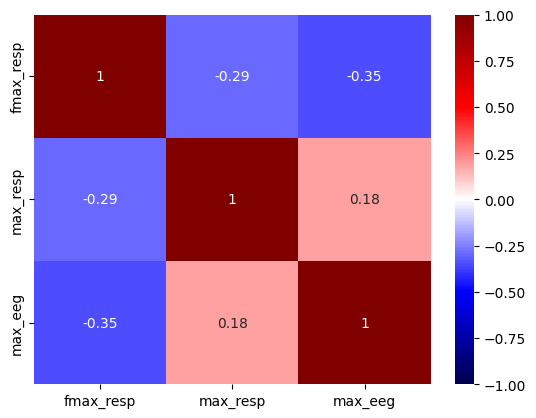

In [3]:
sns.heatmap(power_at_resp.corr(), cmap = 'seismic', vmin = -1 , vmax = 1 , annot = True)

In [4]:
power_at_resp

,participant,session,chan,fmax_resp,max_resp,max_eeg
0,P01,baseline,Fp1,0.36,620.517872,1.169588e-12
1,P01,baseline,Fz,0.36,620.517872,2.607854e-13
2,P01,baseline,F3,0.36,620.517872,1.148734e-12
3,P01,baseline,F7,0.36,620.517872,4.263217e-12
4,P01,baseline,FT9,0.36,620.517872,5.405662e-12
...,...,...,...,...,...,...
1018,P12,odor,FC6,0.32,1587.470266,1.756279e-12
1019,P12,odor,FC2,0.32,1587.470266,1.042073e-12
1020,P12,odor,F4,0.32,1587.470266,7.001000e-13
1021,P12,odor,F8,0.32,1587.470266,2.239714e-12


In [5]:
power_at_resp['log_max_eeg'] = np.log(power_at_resp['max_eeg'].values)

In [6]:
indexes = ['participant','session','chan']
metrics = ['fmax_resp','max_resp','max_eeg','log_max_eeg']

In [7]:
power_at_resp_baselined = df_baseline(df = power_at_resp, indexes = indexes, metrics= metrics, mode = 'substract')

In [8]:
power_at_resp_baselined

,participant,session,chan,fmax_resp,max_resp,max_eeg,log_max_eeg
0,P01,odor,Fp1,0.0,-374.957554,-1.296162e-13,-0.117458
1,P01,odor,Fz,0.0,-374.957554,1.509711e-13,0.456734
2,P01,odor,F3,0.0,-374.957554,-5.721781e-13,-0.689344
3,P01,odor,F7,0.0,-374.957554,-2.490259e-12,-0.877375
4,P01,odor,FT9,0.0,-374.957554,-8.162423e-13,-0.163693
...,...,...,...,...,...,...,...
677,P12,music,FC6,0.0,745.073271,1.312754e-12,0.496307
678,P12,music,FC2,0.0,745.073271,3.090354e-12,1.921908
679,P12,music,F4,0.0,745.073271,1.079038e-12,1.264649
680,P12,music,F8,0.0,745.073271,2.818609e-13,0.083603


<AxesSubplot: xlabel='chan', ylabel='log_max_eeg'>

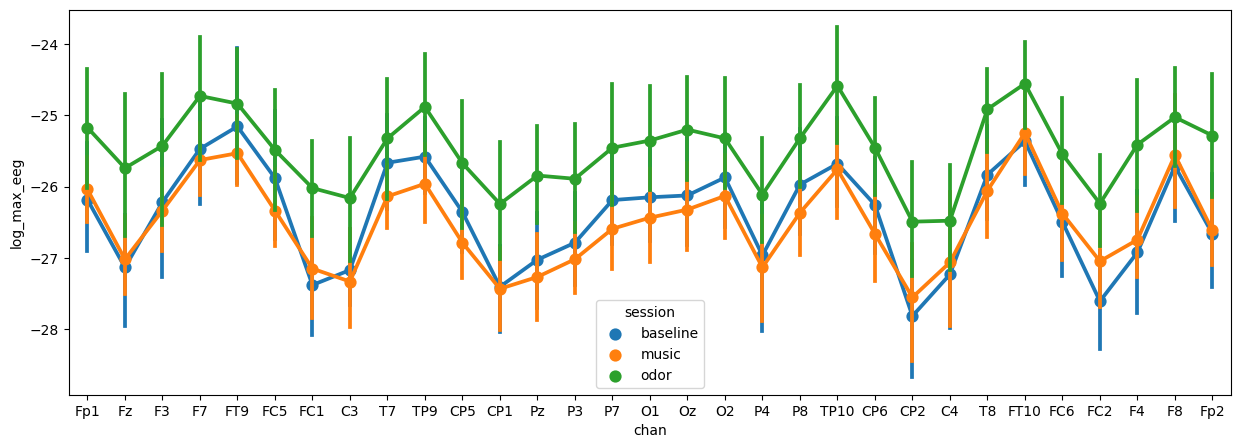

In [9]:
fig, ax = plt.subplots(figsize = (15,5))
sns.pointplot(data = power_at_resp, x = 'chan', y = 'log_max_eeg', hue = 'session',ax=ax)

<AxesSubplot: xlabel='chan', ylabel='log_max_eeg'>

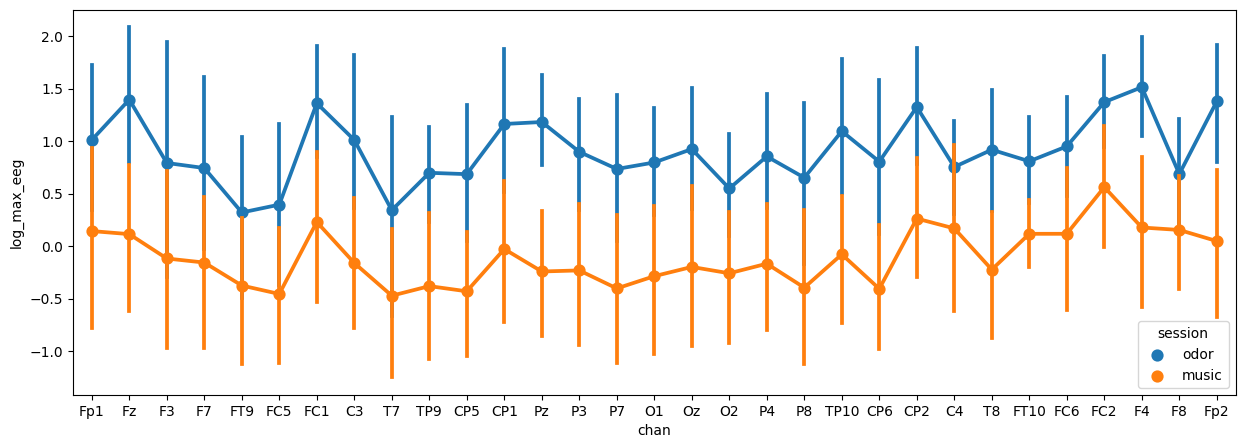

In [10]:
fig, ax = plt.subplots(figsize = (15,5))
sns.pointplot(data = power_at_resp_baselined, x = 'chan', y = 'log_max_eeg', hue = 'session',ax=ax)

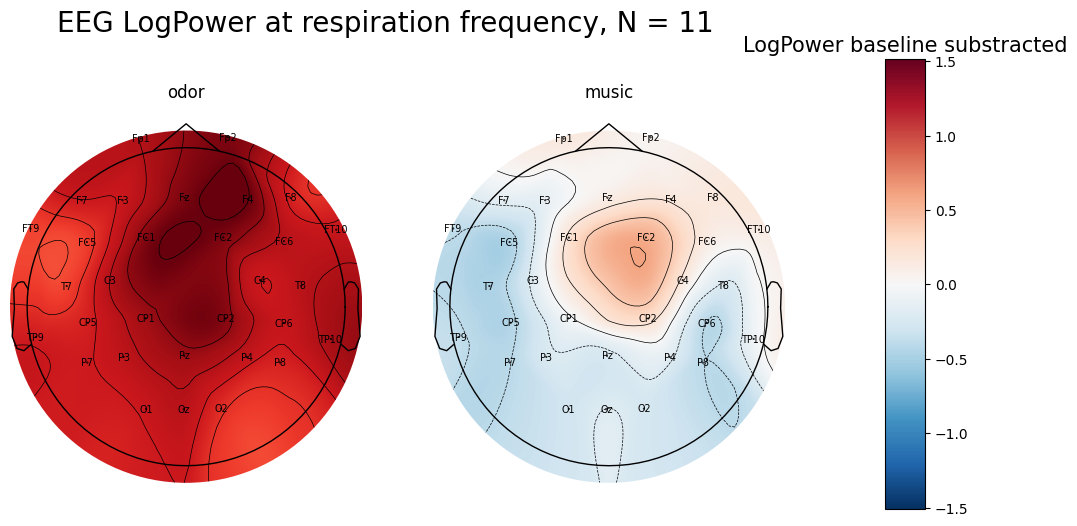

In [11]:
delta_quantile = 0.

colname = 'log_max_eeg'

df = power_at_resp_baselined

N = power_at_resp_baselined['participant'].unique().size

vmin = np.quantile(df.groupby(['session','chan']).mean(numeric_only = True)[colname].values, delta_quantile)
vmax = np.quantile(df.groupby(['session','chan']).mean(numeric_only = True)[colname].values, 1 - delta_quantile)

vmin = vmin if abs(vmin) > abs(vmax) else -vmax
vmax = vmax if abs(vmin) < abs(vmax) else abs(vmin)
    
pos = get_pos()

fig, axs = plt.subplots(ncols = df['session'].unique().size, figsize = (10,5))
fig.suptitle(f'EEG LogPower at respiration frequency, N = {N}', fontsize = 20, y = 1.1)

for c, session in enumerate(df['session'].unique()):
    ax = axs[c]
    topo_data = df[df['session'] == session].groupby('chan').mean(numeric_only = True)[colname].reindex(eeg_chans)
    im, cn = mne.viz.plot_topomap(data =topo_data.values , pos = pos, names = eeg_chans, axes = ax, show = False, vlim = (vmin,vmax))
    ax.set_title(f'{session}')

ax_x_start = 1
ax_x_width = 0.04
ax_y_start = 0.1
ax_y_height = 0.9
cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
clb = fig.colorbar(im, cax=cbar_ax)
clb.ax.set_title('LogPower baseline substracted',fontsize=15)

file = base_folder / 'Figures' / 'power_at_resp' / 'log_substracted_to_baseline.png'

if not os.path.isfile(file):
    print('SAVE')
    fig.savefig(file, bbox_inches = 'tight')

SAVE


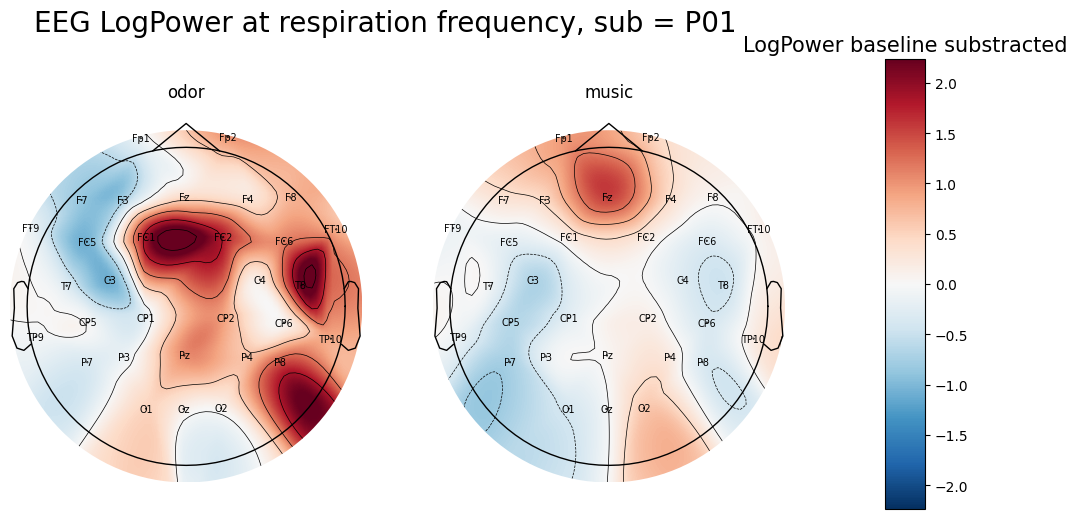

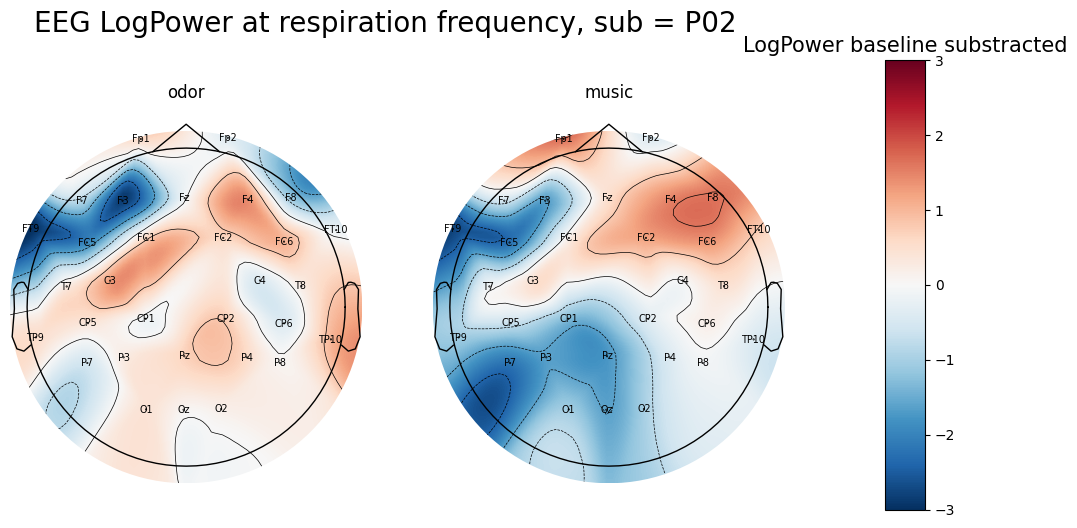

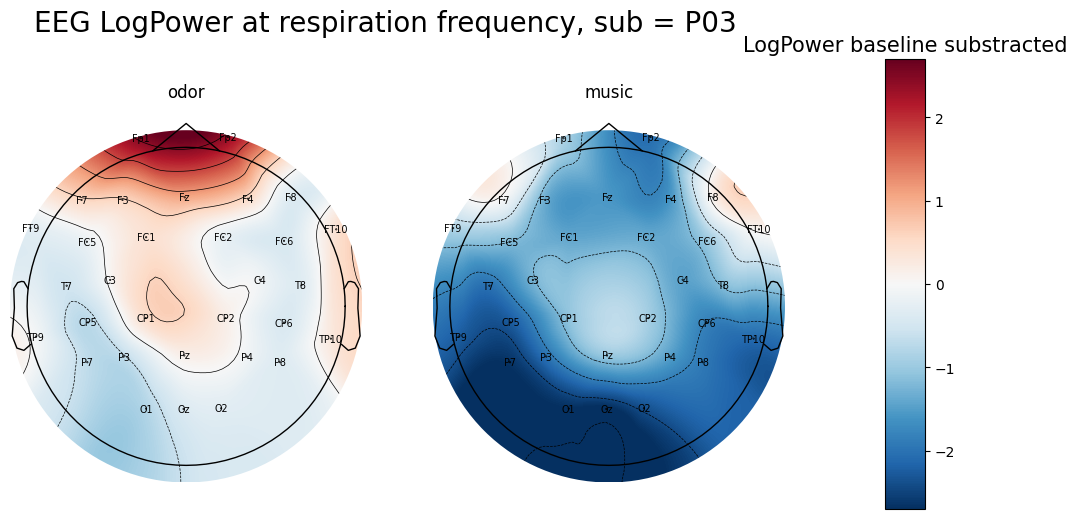

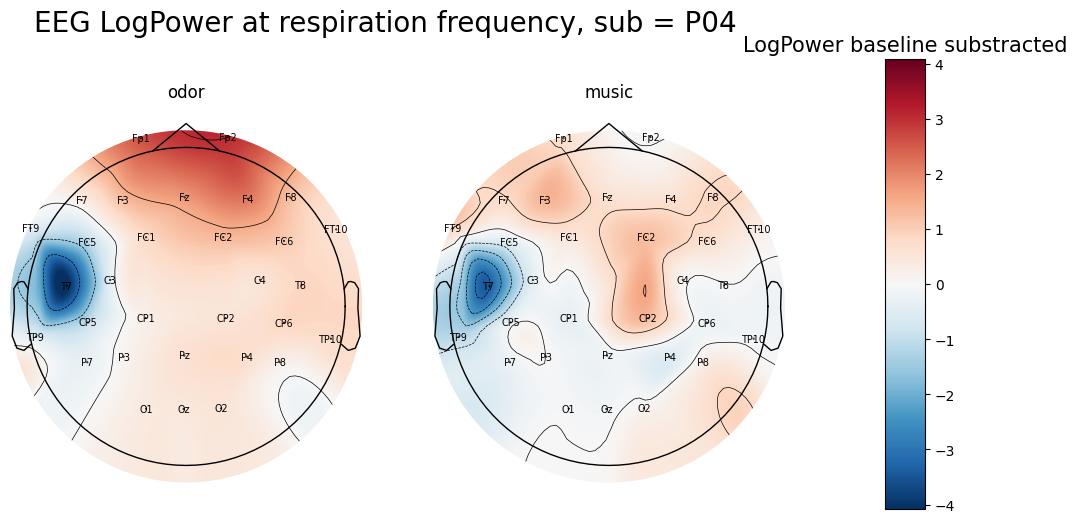

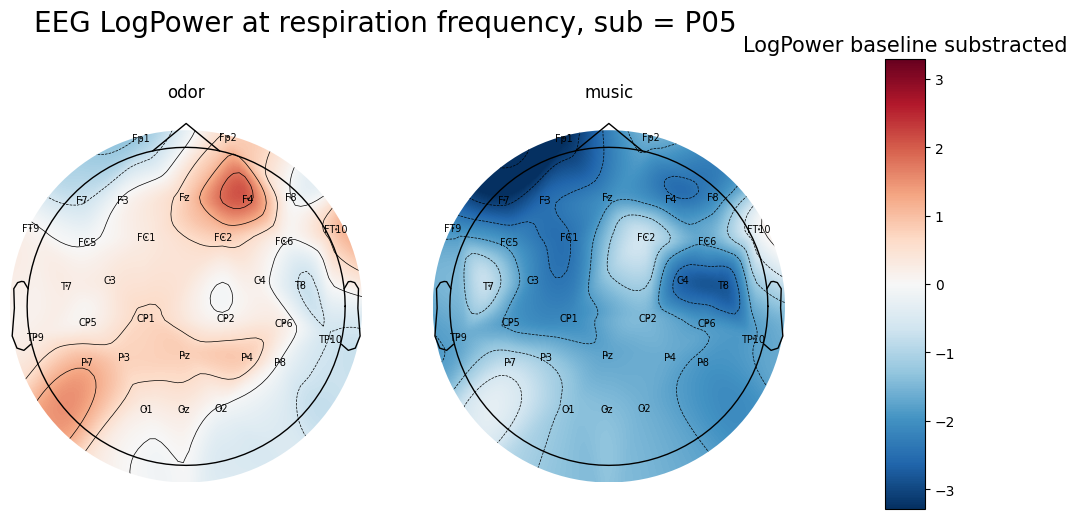

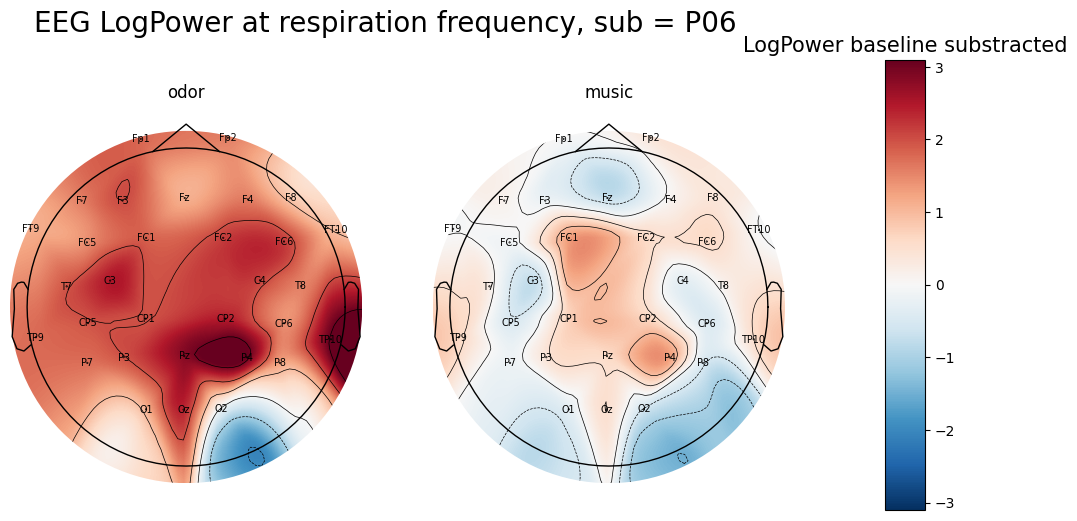

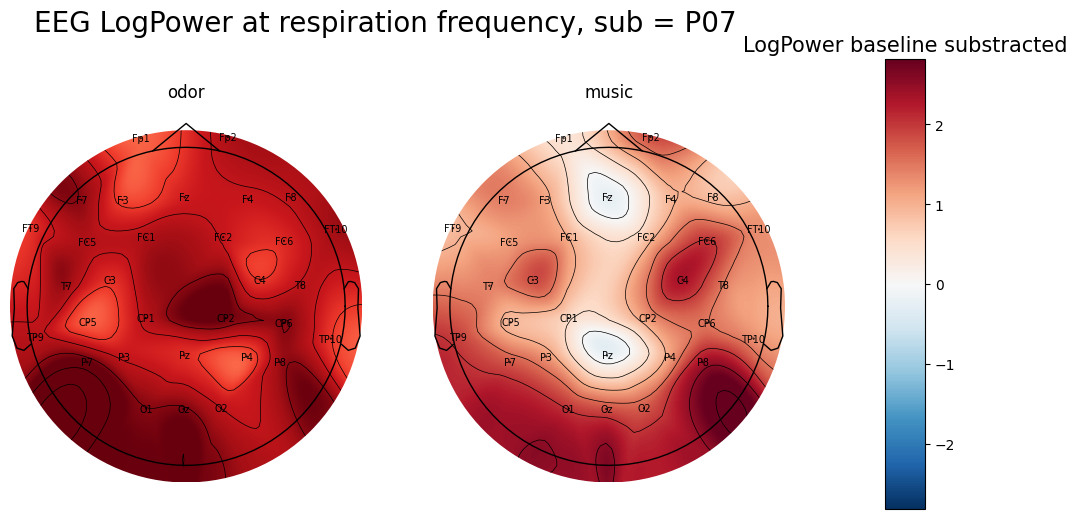

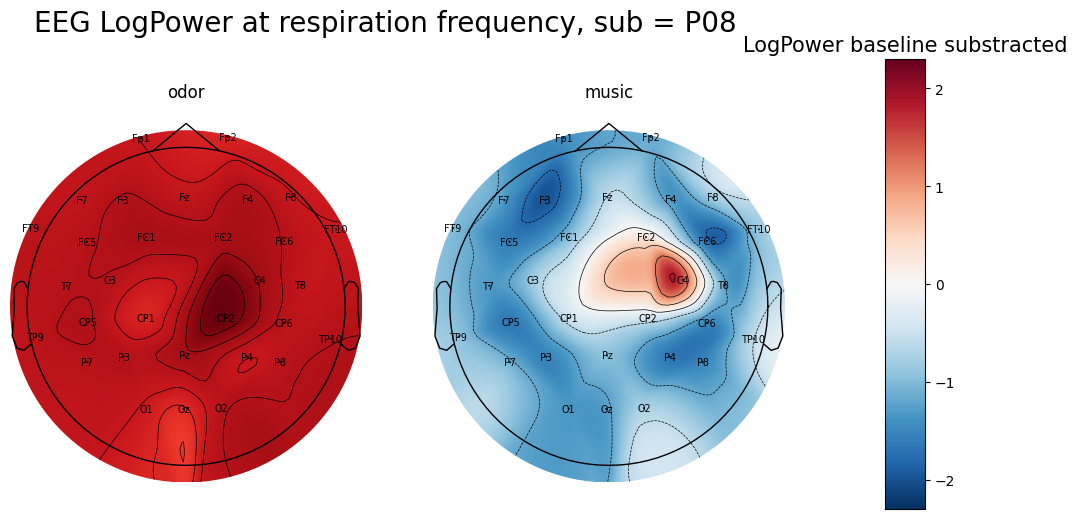

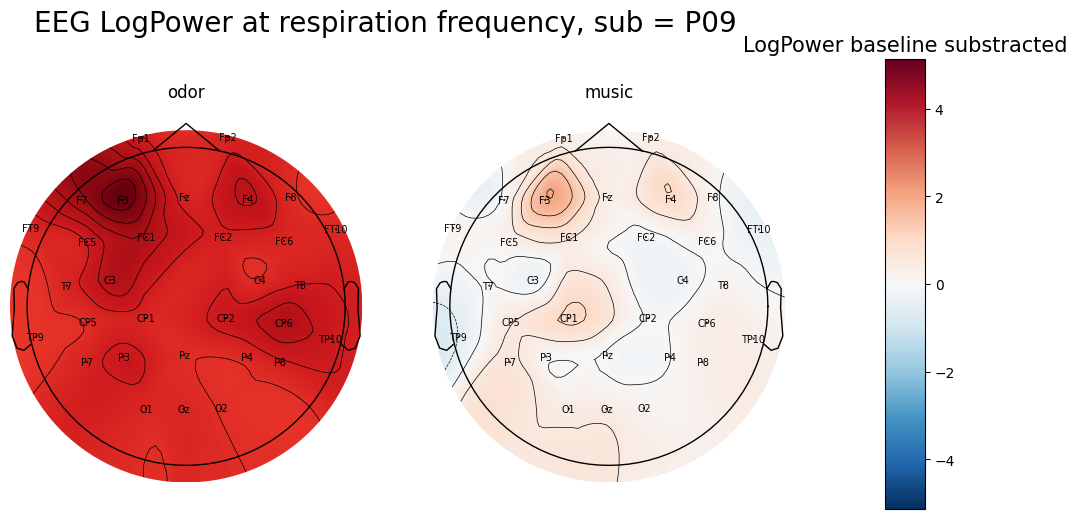

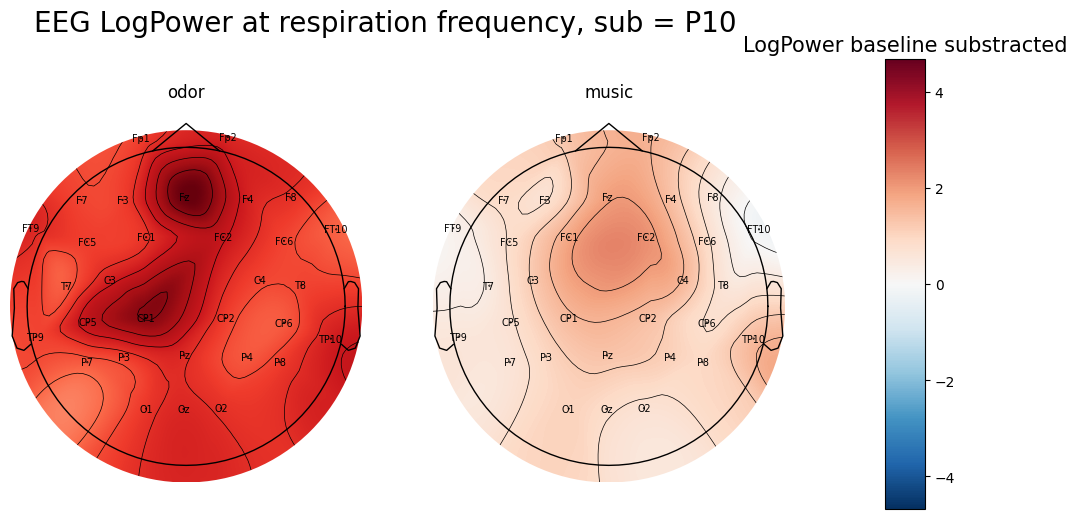

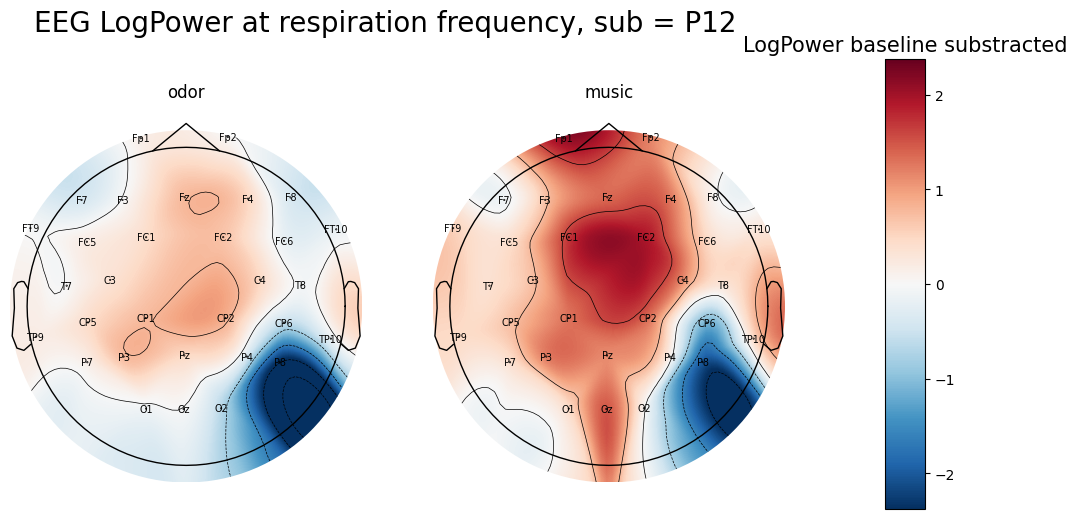

In [12]:
delta_quantile = 0.

colname = 'log_max_eeg'

for subject in subject_keys:
    
    df = power_at_resp_baselined[power_at_resp_baselined['participant'] == subject]
    
    vmin = np.quantile(df.groupby(['session','chan']).mean(numeric_only = True)[colname].values, delta_quantile)
    vmax = np.quantile(df.groupby(['session','chan']).mean(numeric_only = True)[colname].values, 1 - delta_quantile)
    
    vmin = vmin if abs(vmin) > abs(vmax) else -vmax
    vmax = vmax if abs(vmin) < abs(vmax) else abs(vmin)

    pos = get_pos()

    fig, axs = plt.subplots(ncols = df['session'].unique().size, figsize = (10,5))
    fig.suptitle(f'EEG LogPower at respiration frequency, sub = {subject}', fontsize = 20, y = 1.1)

    for c, session in enumerate(df['session'].unique()):
        ax = axs[c]
        topo_data = df[df['session'] == session].groupby('chan').mean(numeric_only = True)[colname].reindex(eeg_chans)
        im, cn = mne.viz.plot_topomap(data =topo_data.values , pos = pos, names = eeg_chans, axes = ax, show = False, vlim = (vmin,vmax))
        ax.set_title(f'{session}')

    ax_x_start = 1
    ax_x_width = 0.04
    ax_y_start = 0.1
    ax_y_height = 0.9
    cbar_ax = fig.add_axes([ax_x_start, ax_y_start, ax_x_width, ax_y_height])
    clb = fig.colorbar(im, cax=cbar_ax)
    clb.ax.set_title('LogPower baseline substracted',fontsize=15)

    file = base_folder / 'Figures' / 'power_at_resp' / 'by_subject' / f'{subject}.png'

    if not os.path.isfile(file):
        print('SAVE')
        fig.savefig(file, bbox_inches = 'tight')